In [1]:
import random
from typing import Any, Dict
import datasets
import torch
import torchvision
from torchvision.transforms import v2 as transforms
import torchvision.transforms.functional as vF
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ok_vqa_builder = datasets.load_dataset_builder('HuggingFaceM4/OK-VQA', trust_remote_code=False)
ok_vqa_builder.download_and_prepare(file_format='arrow')
ds = ok_vqa_builder.as_dataset()
train = ds['train'].to_iterable_dataset(num_shards=8)
valid = ds['validation'].to_iterable_dataset(num_shards=8)
train = train.shuffle(seed=42)
valid = valid.shuffle(seed=42)

Using the latest cached version of the module from /home/eihli/.cache/huggingface/modules/datasets_modules/datasets/HuggingFaceM4--OK-VQA/33fb0e5856ea617c9d69b3feb4c67fba7ff98fd7b38e19bebc285b87e68326fb (last modified on Thu Mar 28 15:57:27 2024) since it couldn't be found locally at HuggingFaceM4/OK-VQA, or remotely on the Hugging Face Hub.
/home/eihli/.virtualenvs/neko/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [3]:
it = iter(train)
example = next(it)

In [4]:
image = example['image']

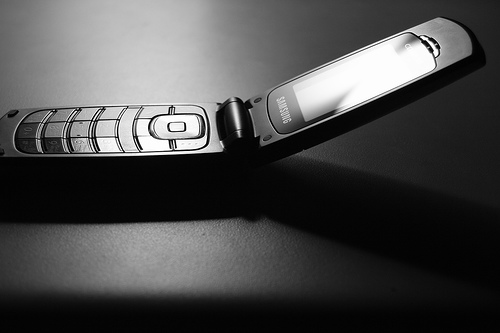

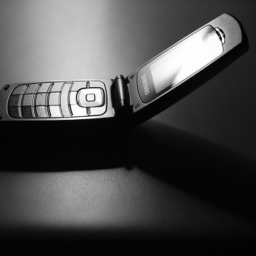

(None, None)

In [5]:
display(image), display(transforms.Resize(size=(256, 256))(image))

In [6]:
class IdentityTransform():
    def __call__(self, sample: Any):
        return sample
        
class VqaDataset(datasets.IterableDataset):
    def __init__(self, dataset: datasets.Dataset, transform=IdentityTransform()):
        self.transform = transform
        self.dataset = dataset.to_iterable_dataset(num_shards=8).shuffle(seed=42)

    def __iter__(self):
        for sample in iter(self.dataset):
            answers = sample['answers']
            del sample['answers']
            sample.update(random.choice(answers))
            yield self.transform(sample)

In [7]:
vqa_transforms = transforms.Compose([
    transforms.PILToTensor(),
    transforms.CenterCrop(size=min(*image.size)),
    transforms.Resize(size=(256, 256))
])

In [8]:
xfids = VqaDataset(ds['train'], vqa_transforms)
xfidsit = iter(xfids)

In [9]:
example = next(xfidsit)
img = example['image']
example

{'image': tensor([[[169, 170, 170,  ...,  49,  49,  48],
          [170, 170, 171,  ...,  50,  49,  48],
          [170, 171, 172,  ...,  50,  50,  49],
          ...,
          [  4,   5,   5,  ...,   4,   4,   3],
          [  4,   5,   5,  ...,   4,   4,   4],
          [  4,   4,   4,  ...,   4,   4,   4]],
 
         [[169, 170, 170,  ...,  49,  49,  48],
          [170, 170, 171,  ...,  50,  49,  48],
          [170, 171, 172,  ...,  50,  50,  49],
          ...,
          [  4,   5,   5,  ...,   4,   4,   3],
          [  4,   5,   5,  ...,   4,   4,   4],
          [  4,   4,   4,  ...,   4,   4,   4]],
 
         [[169, 170, 170,  ...,  49,  49,  48],
          [170, 170, 171,  ...,  50,  49,  48],
          [170, 171, 172,  ...,  50,  50,  49],
          ...,
          [  4,   5,   5,  ...,   4,   4,   3],
          [  4,   5,   5,  ...,   4,   4,   4],
          [  4,   4,   4,  ...,   4,   4,   4]]], dtype=torch.uint8),
 'question_type': 'two',
 'confidence': 2,
 'image_id'

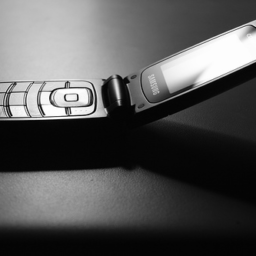

In [10]:
display(vF.to_pil_image(img))

In [11]:
from torch.utils.data import DataLoader

In [12]:
dl = DataLoader(xfids, batch_size=4)

In [13]:
dlit = iter(dl)

In [14]:
batch = next(dlit)
batch['image'].shape

torch.Size([4, 3, 256, 256])

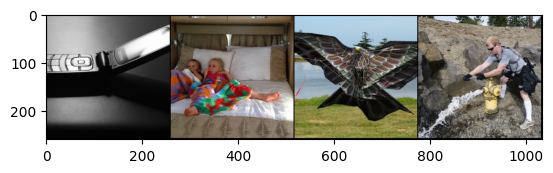

In [15]:
grid = torchvision.utils.make_grid(batch['image'], nrow=4)
plt.imshow(torch.permute(grid, (1, 2, 0)))

In [16]:
from accelerate import Accelerator, DistributedDataParallelKwargs
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm.notebook import tqdm
from gato.policy.gato_policy import GatoPolicy
from gato.training.arguments import TrainingArgs
from gato.training.schedulers import get_linear_warmup_cosine_decay_scheduler
from gato.tasks.vqa_task import VqaTask
from gato.training.trainer import Trainer
from pathlib import Path
import wandb
from transformers import AutoTokenizer
%load_ext autoreload
%autoreload 2

from gato.tasks.vqa_task import VqaTask

In [17]:
accelerator = Accelerator(cpu=True)
args = TrainingArgs(
    training_steps=1,
    log_eval_freq=1,
    warmup_steps=0,
    batch_size=1,
    eval_episodes=1,
    vqa_prop=1,
)

In [24]:
vqa_task = VqaTask(
    DataLoader(VqaDataset(ds['train'], vqa_transforms), batch_size=4),
    DataLoader(VqaDataset(ds['validation'], vqa_transforms), batch_size=4),
)

In [19]:
vqa_task.sample_batch()['image'][[0]].shape

torch.Size([1, 3, 256, 256])

In [20]:
model = GatoPolicy(
    device=args.device,
    embed_dim=args.embed_dim,
    layers=args.layers,
    heads=args.heads,
    dropout=args.dropout,
    mu=args.mu,
    M=args.M,
    patch_size=args.patch_size,
    resid_mid_channels=args.resid_mid_channels,
    continuous_tokens=args.continuous_tokens,
    discrete_tokens=args.discrete_tokens,
    context_len=args.sequence_length,
    use_patch_pos_encoding=not args.disable_patch_pos_encoding,
    use_pos_encoding=not args.disable_inner_pos_encoding,
    activation_fn=args.activation_fn,
    pretrained_lm=args.pretrained_lm,
    flash=args.flash,
    tokenizer_model_name=args.tokenizer_model_name,
    pad_seq=args.pad_seq,
)
model.text_tokenizer.pad_token = model.text_tokenizer.eos_token

In [21]:
batch = vqa_task.sample_batch()
model.text_tokenizer(batch['question'])

{'input_ids': [[13828, 1748, 318, 8096, 287, 262, 2939, 30], [2061, 318, 428, 582, 3375, 546, 30], [8241, 318, 4762, 284, 423, 15646, 262, 4235, 286, 9358, 1775, 287, 428, 2939, 30], [2061, 338, 262, 1266, 20186, 329, 428, 3074, 30]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
vqa_task.evaluate(model, log_examples_to_output=True)

--- examples ---
Target answer: andre horton 
 Predicted answer : o
----
